In [ ]:
# -*- coding: utf-8 -*-
import numpy
import pandas
import matplotlib.pyplot as plt

from sklearn import preprocessing
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.layers.recurrent import LSTM

class Prediction :

    def __init__(self):
        self.length_of_sequences = 10
        self.in_out_neurons = 1
        self.hidden_neurons = 350

    def load_data(self, data, n_prev=10):
        X, Y = [], []
        for i in range(len(data) - n_prev):
            #学習データとラベルを作成
            X.append(data.iloc[i:(i+n_prev)].as_matrix())
            Y.append(data.iloc[i+n_prev].as_matrix())
        retX = numpy.array(X)
        retY = numpy.array(Y)
        return retX, retY


    def create_model(self) :
        model = Sequential()
        #LSTM一層作成
        model.add(LSTM(self.hidden_neurons, \
                  batch_input_shape=(None, self.length_of_sequences, self.in_out_neurons), \
                  return_sequences=False))
        #全結合層
        model.add(Dense(self.in_out_neurons))
        #活性化関数
        model.add(Activation("linear"))
        #重み更新
        model.compile(loss="mape", optimizer="adam")
        return model


    def train(self, X_train, y_train) :
        model = self.create_model()
        # 学習
        model.fit(X_train, y_train, batch_size=10, nb_epoch=100)
        return model


if __name__ == "__main__":

    prediction = Prediction()

  # データ準備
    data = None
    #２００７年から2017年までのデータを仕様
    for year in range(2007, 2017):
        #データread
        data_ = pandas.read_csv('csv/indices_I101_1d_' + str(year) +  '.csv',encoding='shift-jis')
        #データをひとまとまりにする
        data = data_ if (data is None) else pandas.concat([data, data_])
    #カラム名変更
    data.columns = ['date', 'open', 'high', 'low', 'close']
    data['date'] = pandas.to_datetime(data['date'], format='%Y-%m-%d')
  # 終値のデータを標準化
    data['close'] = preprocessing.scale(data['close'])
    #日でソーティングする
    data = data.sort_values(by='date')
    #インデックスをリセットする
    data = data.reset_index(drop=True)
    #日と終値のみのデータにする。
    data = data.loc[:, ['date', 'close']]

  # 2割をテストデータへ
    split_pos = int(len(data) * 0.8)
    x_train, y_train = prediction.load_data(data[['close']].iloc[0:split_pos], prediction.length_of_sequences)
    x_test,  y_test  = prediction.load_data(data[['close']].iloc[split_pos:], prediction.length_of_sequences)

    model = prediction.train(x_train, y_train)
    
    predicted = model.predict(x_test)
    

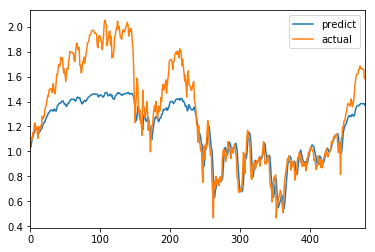

In [4]:
result = pandas.DataFrame(predicted)
result.columns = ['predict']
result['actual'] = y_test
result.plot()
plt.show()